In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Example with additional parameters
circular_path = pd.read_csv('circular_path_data.csv', delimiter=',', encoding='utf-8', header=0)
pioneer_odom = pd.read_csv('pioneer_odom.csv', delimiter=',', encoding='utf-8', header=0)
obstacle_odom = pd.read_csv('obstacle_odom.csv', delimiter=',', encoding='utf-8', header=0)
obstacle_detection_pioneer = pd.read_csv('obstacle_detection_pioneer.csv', delimiter=',', encoding='utf-8', header=0)

In [16]:
obstacle_detection_pioneer.head()

,Time,X til,X_robot_solver,Y_robot_solver,X_solver_robot,Y_solver_robot,X_robot_obs,Y_robot_obs,X_obs_robot,Y_obs_robot,X_dot,Y_dot
0,1.688252e+09,0.327628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
1,1.688252e+09,0.332807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1.688252e+09,0.338077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1.688252e+09,0.343294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
4,1.688252e+09,0.345911,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [17]:
pioneer_odom.head()

,Time,X,Y,X_controle,Y_controle,W,Xd,Yd,Wd
0,1.688252e+09,0.951455,-0.430574,1.005987,-0.290837,1.198728,0.000000,0.000000,0.000000
1,1.688252e+09,0.951412,-0.430649,1.005959,-0.290919,1.198613,-0.002622,-0.004501,-0.006893
2,1.688252e+09,0.951441,-0.430522,1.005960,-0.290781,1.198817,0.001741,0.007617,0.012245
3,1.688252e+09,0.951440,-0.430530,1.005961,-0.290789,1.198801,-0.000046,-0.000457,-0.000926
4,1.688252e+09,0.951389,-0.430610,1.005924,-0.290875,1.198704,-0.003045,-0.004814,-0.005860


In [18]:
obstacle_detection_pioneer['X_robot_solver'][0]

nan

In [27]:
%%time
def find_closest_arg(arr, target):
    # Expand dimensions of the array and target for broadcasting
    arr = np.expand_dims(arr, axis=0)
    target = np.expand_dims(target, axis=1)
    
    # Calculate the absolute difference between the array and the target values
    diff = np.abs(arr - target)
    
    # Find the index of the minimum difference for each target value
    closest_arg = np.argmin(diff, axis=1)
    
    return closest_arg


def poda(*args, column='Time'):
    
    biggest_first_value = -np.inf
    smallest_last_value = np.inf

    smallest_dataset = np.inf

    for arg in args:
        length = len(arg)

        if length < smallest_dataset:
            smallest_dataset = length

        if arg[column].iloc[0] > biggest_first_value:
            biggest_first_value = arg[column].iloc[0]
        
        if arg[column].iloc[-1] < smallest_last_value:
            smallest_last_value = arg[column].iloc[-1]
    
    times = np.linspace(biggest_first_value, smallest_last_value, num=smallest_dataset)
    new_datasets = []

    fps = int(1/((smallest_last_value - biggest_first_value)/smallest_dataset))

    for arg in args:
        indices = find_closest_arg(arg[column], times)

        data = arg.iloc[indices]
        data.reset_index(drop=True, inplace=True)
        new_datasets.append(data)
    
    return new_datasets, fps

circular_path, pioneer_odom, obstacle_odom, obstacle_detection_pioneer, fps = poda(circular_path, pioneer_odom, obstacle_odom, obstacle_detection_pioneer)

30
CPU times: user 155 ms, sys: 89.1 ms, total: 244 ms
Wall time: 240 ms


In [20]:
circular_path.head() 

,Time,X,Y,VX,VY
0,1.688252e+09,0.999229,0.039257,-0.006166,0.156959
1,1.688252e+09,0.999009,0.044501,-0.006990,0.156924
2,1.688252e+09,0.998763,0.049718,-0.007810,0.156885
3,1.688252e+09,0.998489,0.054951,-0.008632,0.156842
4,1.688252e+09,0.998188,0.060178,-0.009453,0.156795


In [21]:
pioneer_odom.head()

,Time,X,Y,X_controle,Y_controle,W,Xd,Yd,Wd
0,1.688252e+09,0.951408,-0.430652,1.005952,-0.290920,1.198636,0.000476,-0.003812,-0.011071
1,1.688252e+09,0.951458,-0.430591,1.006005,-0.290861,1.198619,0.002572,0.003357,-0.000087
2,1.688252e+09,0.951390,-0.430617,1.005928,-0.290883,1.198680,-0.000987,0.001305,0.001953
3,1.688252e+09,0.951422,-0.430616,1.005956,-0.290880,1.198705,-0.001091,-0.005161,-0.007822
4,1.688252e+09,0.951406,-0.430617,1.005939,-0.290881,1.198719,-0.002543,-0.001315,0.005487


In [22]:
def rotation_matrix(theta):
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    rotation = np.array([[cos_theta, -sin_theta, 0],
                         [sin_theta, cos_theta, 0],
                         [0, 0, 1]])

    return rotation

In [23]:
robot_heigth = 0.7/2
robot_width = 0.6/2

thetas = np.linspace(0, 2 * np.pi, 10)
x = robot_heigth * np.cos(thetas)
y = robot_width * np.sin(thetas)

pioneer = np.array([x, y, np.ones(len(x))])

rot_pioneer = np.dot(pioneer.T, rotation_matrix(pioneer_odom.iloc[0]['W']))
rot_pioneer_x = rot_pioneer[:, 0] + pioneer_odom.iloc[0]['X']
rot_pioneer_y = rot_pioneer[:, 1] + pioneer_odom.iloc[0]['Y']

(-1.1823279271814626,
 1.364489880946202,
 -1.1453990465081674,
 1.1647970318015215)

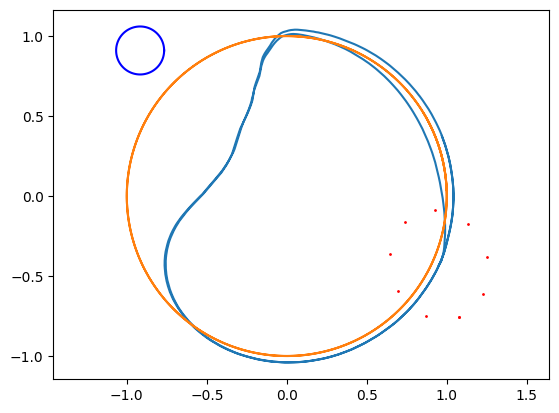

In [24]:
plt.plot(pioneer_odom['X'], pioneer_odom['Y'])
plt.plot(circular_path['X'], circular_path['Y'])
plt.scatter(rot_pioneer_x, rot_pioneer_y, s=1, c='r')
theta = np.linspace(0, 2 * np.pi, 100)
radius = 0.3/2
x = radius * np.cos(theta)
y = radius * np.sin(theta)

# Plot the circle
plt.plot(x-0.916639, y+0.909807, color='b')
plt.axis('equal')

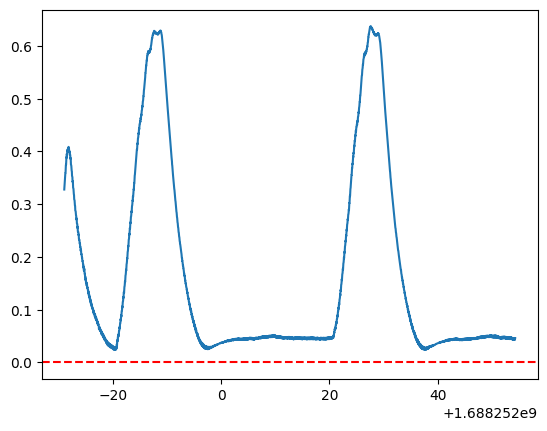

In [25]:
plt.axhline(y=0.0, color='r', linestyle='--')

plt.plot(obstacle_detection_pioneer['Time'], obstacle_detection_pioneer['X til'])
plt.show()
